In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from joblib import Parallel, delayed
from collections import Counter
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import MultiPoint, Polygon
from scipy.interpolate import splprep, splev
sns.set_style("white")

class Silhouette:
    @staticmethod
    def Micro(X, labels):
        """
        Compute the micro-averaged silhouette score for all samples.
        Parameters:
        - X: array-like of shape (n_samples, n_features). Input data points.
        - labels: array-like of shape (n_samples,). Cluster labels for each sample.
        Returns:
        - float: The micro-averaged silhouette score.
        """
        return silhouette_score(X, labels)

    @staticmethod
    def Macro(X, labels):
        """
        Compute the macro-averaged silhouette score.
        Parameters:
        - X: array-like of shape (n_samples, n_features). Input data points.
        - labels: array-like of shape (n_samples,). Cluster labels for each sample.
        Returns:
        - float: The macro-averaged silhouette score.
        """
        silhouette_vals = silhouette_samples(X, labels)
        unique_labels = np.unique(labels)
        cluster_means = [
            np.mean(silhouette_vals[labels == lbl]) for lbl in unique_labels
        ]
        return np.mean(cluster_means) if cluster_means else 0

    @staticmethod
    def Convex(X, labels, alpha=0.5):
        """
        Compute a convex combination of micro-averaged and macro-averaged silhouette scores.
        Parameters:
        - X: array-like of shape (n_samples, n_features). Input data points.
        - labels: array-like of shape (n_samples,). Cluster labels for each sample.
        Returns:
        - float: The convex combination of the silhouette scores.
        """
        S_micro = Silhouette.Micro(X, labels)
        S_macro = Silhouette.Macro(X, labels)
        return alpha * S_micro + (1 - alpha) * S_macro

class KSilDemo:
    def __init__(self,
                 n_clusters=3,
                 init_method='random',
                 max_iter=100,
                 random_state=42,
                 silhouette_objective='macro',
                 approximation = False,
                 sample_size=-1,
                 weighting='power',
                 sensitivity=2,
                 n_jobs=-1,
                 alpha=0.5,
                 tol=1e-4):

        # Parameters
        self.n_clusters = n_clusters
        self.init_method = init_method
        self.max_iter = max_iter
        self.random_state = random_state
        self.silhouette_objective = silhouette_objective
        self.approximation = approximation
        self.sample_size = sample_size
        self.weighting = weighting
        self.sensitivity = sensitivity
        self.n_jobs = n_jobs
        self.alpha = alpha
        self.tol = tol

        # Attributes
        self.labels_ = None
        self.cluster_centers_ = None
        self.n_iter_ = None
        self.history = None

    def _initialize_centroids_kmeans(self, X, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='random',
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = pd.Series(list(kmeans.cluster_centers_), index=range(n_clusters))
        return centers, kmeans.labels_

    def _initialize_centroids_kmeansplus(self, X, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = pd.Series(list(kmeans.cluster_centers_), index=range(n_clusters))
        return centers, kmeans.labels_

    def _initialize_centroids(self, X, n_clusters):
        if self.init_method == 'random':
            return self._initialize_centroids_kmeans(X, n_clusters)
        elif self.init_method == 'k-means++':
            return self._initialize_centroids_kmeansplus(X, n_clusters)
        else:
            raise ValueError('"init_method" must be either "random" or "k-means++".')

    def _uniform_sampling(self, X, labels, size):
        indices = np.random.choice(len(X), size=size, replace=False)
        num_sampled = len(indices)
        num_clusters = len(np.unique(labels[indices]))
        if num_sampled <= num_clusters:
            raise ValueError(
                f"Uniform Sampling produced only {num_sampled} samples for {num_clusters} clusters. "
                "Increase sample_size."
            )
        return indices

    def _balanced_sampling(self, X, labels, size):
        unique_clusters = np.unique(labels)
        samples_per_cluster = max(1, size // len(unique_clusters))
        indices_list = []
        for cluster_label in unique_clusters:
            cluster_indices = np.where(labels == cluster_label)[0]
            if len(cluster_indices) == 0:
                continue
            chosen_size = min(len(cluster_indices), samples_per_cluster)
            if chosen_size == 0:
                continue
            chosen_indices = np.random.choice(cluster_indices, size=chosen_size, replace=False)
            indices_list.append(chosen_indices)
        if indices_list:
            indices = np.concatenate(indices_list)
        else:
            indices = np.array([], dtype=int)
        if indices.shape[0] <= len(unique_clusters):
            raise ValueError(
                f"Balanced Sampling produced only {indices.shape[0]} samples for {len(unique_clusters)} clusters. "
                "Increase sample_size."
            )
        return indices

    def _sample_data(self, X, labels):
        n_samples = len(X)
        labels = np.array(labels)

        if self.sample_size == -1:
            return np.arange(n_samples)
        elif 0 <= self.sample_size <= 1:
            size = int(np.ceil(self.sample_size * n_samples))
        elif self.sample_size > 1:
            size = int(self.sample_size)
        else:
            raise ValueError(
                "sample_size must be -1, a fraction (between 0 and 1), or an exact number of data points."
            )

        if size == 0:
            raise ValueError("Sample size computed as 0. Increase sample_size or adjust the parameters.")

        if self.silhouette_objective == 'macro':
            return self._balanced_sampling(X, labels, size)
        elif self.silhouette_objective in ['micro', 'convex']:
            return self._uniform_sampling(X, labels, size)
        else:
            raise ValueError(
                "Invalid 'silhouette_objective'. Expected 'macro', 'micro', or 'convex'."
            )

    def _compute_silhouette_scores(self, X, labels, centers):
        if len(X) == 0:
            return pd.DataFrame({'labels': [], 'points': [], 'silhouette': []})

        labels = np.asarray(labels)

        # (approximation=False) Exact silhouette computation:
        if not self.approximation:
            point_silhouette_scores = silhouette_samples(X, labels=labels)
            return pd.DataFrame({
                'labels': labels,
                'points': X.tolist(),
                'silhouette': point_silhouette_scores
            })

        # (approximation=True) Approximate silhouette computation:
        # Map labels to 0-based indices
        if hasattr(centers, 'index'):
            # Ensure every cluster present in labels has a centroid in centers
            unique_labels = np.unique(labels)
            for cl in unique_labels:
                if cl not in centers.index:
                    # If centroid not present, compute it as the mean of its cluster's points
                    centers.at[cl] = np.mean(X[labels == cl], axis=0).tolist()
            # Sort the centers by index for consistency
            centers = centers.sort_index()
            clusters = centers.index.to_numpy()
            mapping = {c: i for i, c in enumerate(clusters)}
            inv = np.array([mapping[label] for label in labels])
        else:
            clusters = np.arange(len(centers))
            inv = labels  # assuming labels are already 0-based integers

        k = len(clusters)
        n = X.shape[0]

        # Convert stored centers to a np.array
        centers_arr = np.array(centers.tolist())

        # Compute differences and squared distances between each point and its assigned centroid
        diffs = X - centers_arr[inv]       # shape: (n, d)
        dists_sq = np.sum(diffs**2, axis=1)  # shape: (n,)

        # Compute per-cluster counts and within-cluster sum-of-squares (SS)
        counts = np.bincount(inv, minlength=k)
        SS_arr = np.bincount(inv, weights=dists_sq, minlength=k)

        # Compute the full distance matrix from every point to every stored centroid
        D = cdist(X, centers_arr, metric='euclidean')

        # Extract for each point the distance to its own centroid
        D_diag = D[np.arange(n), inv]

        # For each point, get the count and SS corresponding to its cluster
        count_vec = counts[inv]
        ss_vec = SS_arr[inv]

        # Compute intra-cluster distance a(x_i)
        a_vals = np.where(
            count_vec > 1,
            np.sqrt((count_vec * (D_diag ** 2) + ss_vec) / (count_vec - 1)),
            D_diag
        )

        # Compute candidate distances for b(x_i):
        # candidate_matrix[i, j] = sqrt( D[i, j]^2 + (SS_arr[j] / counts[j]) )
        cluster_term = SS_arr / np.maximum(counts, 1e-6)
        candidate_matrix = np.sqrt(D ** 2 + cluster_term.reshape(1, k))

        # Exclude the candidate corresponding to the point's own cluster
        candidate_matrix[np.arange(n), inv] = np.inf

        # For each point, b(x_i) is the minimum candidate value.
        b_vals = np.min(candidate_matrix, axis=1)

        # Maximum of a(x_i), b(x_i)
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-6) # Avoid division by zero

        # Compute the silhouette scores
        s_vals = (b_vals - a_vals) / max_ab

        return pd.DataFrame({
            'labels': labels,
            'points': X.tolist(),
            'silhouette': s_vals
        })

    def _compute_silhouette_micro(self, silhouette_data):
        if silhouette_data.empty:
            return 0
        return silhouette_data['silhouette'].mean()

    def _compute_silhouette_macro(self, silhouette_data):
        silhouette_per_cluster = silhouette_data.groupby('labels')['silhouette']
        if silhouette_per_cluster.size == 0:
            return 0
        cluster_silhouette = silhouette_per_cluster.mean()
        return cluster_silhouette.mean()

    def _compute_silhouette_convex(self, S_micro, S_macro):
        return self.alpha * S_micro + (1 - self.alpha) * S_macro

    def _power_weights(self, silhouette_data, sensitivity):
        # Compute shifted silhouette scores in each cluster by subtracting the minimum silhouette score
        silhouette_data['shifted_s'] = silhouette_data.groupby('labels')['silhouette'].transform(lambda s: s-s.min()+1e-6)

        # Compute the median of shifted silhouette scores
        silhouette_data['median_s'] = silhouette_data.groupby('labels')['shifted_s'].transform('median')

        # Assign weights to each data point by computing the ratio of its shifted silhouette score to the median silhouette
        # Raising this ratio to the power of 'sensitivity' emphasizes points that are above the median (or de-emphasizes those below)
        silhouette_data['weight'] = (silhouette_data['shifted_s']/silhouette_data['median_s'])**sensitivity

        return silhouette_data.drop(columns=['shifted_s', 'median_s'])

    def _exponential_weights(self, silhouette_data, sensitivity):
        # Rank points within each cluster by their silhouette scores in descending order
        silhouette_data['silhouette_rank'] = silhouette_data.groupby('labels')['silhouette'] \
                                                          .rank(method='dense', ascending=False) \
                                                          .astype(int) # Dense to get "tie" ranks

        # Compute the maximum rank within each cluster
        max_rank = silhouette_data.groupby('labels')['silhouette_rank'].transform('max')

        # Approximate the median rank and define a normalization factor
        median_rank = (max_rank + 1) / 2.0

        # Scale to ensure that the exponential function behaves consistently
        scaler = max_rank / 2.0
        scaler = scaler.replace(0, 1)  # Avoid zero division

        # Compute normalized distance from the median rank
        normalized_dist = (silhouette_data['silhouette_rank'] - median_rank) / scaler

        # Compute weights using the exponential scaling formula
        silhouette_data['weight'] = np.exp(-normalized_dist * sensitivity)

        return silhouette_data.drop(columns=['silhouette_rank'])

    def _assign_weights(self, silhouette_data, sensitivity=2.0):
        if self.weighting == 'power':
            return self._power_weights(silhouette_data, sensitivity)
        elif self.weighting == 'exponential':
            return self._exponential_weights(silhouette_data, sensitivity)
        else:
            raise ValueError(
                'Invalid "weighting" parameter, must be either "power" or "exponential".'
            )

    def _update_centroids_weighted(self, n_clusters, weighted_data, previous_centers):
        def compute_weighted_mean(cluster):
            # Filter data points belonging to the current cluster
            cluster_points = weighted_data[weighted_data['labels'] == cluster]
            if not cluster_points.empty:
                # Points column to np.array
                points = np.array(cluster_points['points'].tolist())
                # Weights into (column) vector
                weights = cluster_points['weight'].values.reshape(-1, 1)
                weighted_sum = np.sum(points * weights, axis=0)
                total_weight = np.sum(weights)
                if total_weight != 0:
                    weighted_mean = weighted_sum / total_weight
                else:
                    weighted_mean = np.mean(points, axis=0)
                return weighted_mean.tolist()
            else:
                return None  # Indicate no points assigned

        jobs = self.n_jobs if n_clusters>=10 else 1 # No parallelization when clusters<10
        results = Parallel(n_jobs=jobs)(
            delayed(compute_weighted_mean)(cluster) for cluster in range(n_clusters)
        )

        # Compile the new centroids, using the previous centroid if a cluster has no points
        # Empty cluster centroids will be re-initialized afterwards
        # but we retain previous centroid to avoid inconsistencies
        new_centers = []
        for cluster, centroid in enumerate(results):
            if centroid is not None:
                new_centers.append(centroid)
            else:
                # Retain the previous centroid if empty
                if cluster < len(previous_centers):
                    new_centers.append(previous_centers[cluster])
                else:
                    # If previous_centers does not have an entry for this cluster
                    raise KeyError(f"Previous centers do not contain cluster {cluster}.")

        return pd.Series(new_centers)

    def _assign_clusters(self, X, centers):
        # Centers to a np.array for efficient computation.
        centers_array = np.array(centers.tolist())
        dist_matrix = pairwise_distances(X, centers_array, metric='euclidean', n_jobs=self.n_jobs)
        labels = np.argmin(dist_matrix, axis=1)
        return labels

    def _reinitialize_empty_clusters(self, n_clusters, centers, labels, X):
        # Identify empty clusters
        empty_clusters = list(set(range(n_clusters)) - set(labels))

        if not empty_clusters:
            # If no empty clusters: No reinitialization needed
            return centers, labels

        # Determine the largest cluster (the cluster with the most data points)
        largest_cluster_label = Counter(labels).most_common(1)[0][0]

        # Ensure that the largest_cluster_label exists in centers (Optional)
        # Unnecessary because of the 'previous_centers' in centroids update
        # But we include it as a safeguard
        if largest_cluster_label not in centers.index:
            # Initialize the missing cluster center by computing the mean of its points
            points_in_largest = X[labels == largest_cluster_label]
            if points_in_largest.size == 0:
                raise ValueError(f"Largest cluster label {largest_cluster_label} has no points assigned.")
            new_centroid = points_in_largest.mean(axis=0)
            centers.at[largest_cluster_label] = list(new_centroid)

        # Retrieve the centroid of the largest cluster
        largest_centroid = np.array(centers[largest_cluster_label])

        # Get indices of points in the largest cluster
        largest_cluster_indices = np.where(labels == largest_cluster_label)[0]
        cluster_arr = X[largest_cluster_indices]

        # For each empty cluster, reinitialize it using a point from the largest cluster
        for empty_cluster in empty_clusters:
            if cluster_arr.size == 0:
                # No more points to assign
                break

            # Compute distances from all points in the largest cluster to its centroid
            dist_vector = pairwise_distances(cluster_arr, [largest_centroid], metric='euclidean', n_jobs=self.n_jobs).ravel()

            # Identify the index of the furthest point
            max_idx = dist_vector.argmax()

            # Get the actual index of this furthest point in the dataset
            furthest_point_idx = largest_cluster_indices[max_idx]

            # Retrieve the coordinates of the furthest point
            furthest_point_arr = X[furthest_point_idx]

            # Update the centroid of the empty cluster to be this furthest point
            if empty_cluster in centers.index:
                centers.at[empty_cluster] = list(furthest_point_arr)  # Ensure it's a list to match structure
            else:
                # If the empty cluster label is not in centers, add it
                centers.at[empty_cluster] = list(furthest_point_arr)

            # Reassign the label of this point to the newly initialized cluster label
            labels[furthest_point_idx] = empty_cluster

            # Remove the reassigned point from cluster_arr and largest_cluster_indices to avoid re-selection
            cluster_arr = np.delete(cluster_arr, max_idx, axis=0)
            largest_cluster_indices = np.delete(largest_cluster_indices, max_idx)

        # Validate that all clusters now have at least one assigned point
        unique_labels = set(labels)
        if len(unique_labels) != n_clusters:
            missing_clusters = set(range(n_clusters)) - unique_labels
            raise ValueError(f"Expected {n_clusters} clusters, but got {len(unique_labels)}. Missing clusters: {missing_clusters}.")

        return centers, labels

    def _check_centroid_stability(self, previous_centers, centers, n_clusters, X_shape):
        total_movement = 0.0

        for cluster in range(n_clusters):
            # Previous centroid
            prev_centroid = np.array(previous_centers.get(cluster, [0] * X_shape[1]))

            # Current centroid
            curr_centroid = np.array(centers.get(cluster, [0] * X_shape[1]))

            # Euclidean norm of movement
            total_movement += np.linalg.norm(curr_centroid - prev_centroid)

        return (total_movement / n_clusters) < self.tol

    def _KSil(self, X, n_clusters, max_iter, sensitivity):
        # Set random seed
        np.random.seed(self.random_state)

        # Retain a copy of the full dataset
        X_full = X.copy()

        # Initialize centroids and labels
        centers, labels = self._initialize_centroids(X_full, n_clusters)

        history = []
        history.append((centers.copy(), labels.copy()))

        # If sampling is enabled, obtain fixed sample indices from the full dataset
        if self.sample_size != -1:
            sample_indices = self._sample_data(X_full, labels)
            X = X_full[sample_indices] # X_full sampled
        else:
            sample_indices = np.arange(len(X_full)) # All indices (no sampling)
            X = X_full

        # Initialize variables to track the best clustering solution
        best_score = -1
        best_centers, best_labels = centers.copy(), labels.copy()

        for n_iter in range(1, max_iter + 1):
            # Update the sampled labels from full dataset using the fixed sample indices
            labels_sampled = labels[sample_indices] # If sampling was enabled

            # Compute point-silhouette scores
            silhouette_data = self._compute_silhouette_scores(X, labels_sampled, centers)

            # Calculate the silhouette objective score
            if self.silhouette_objective == 'convex':
                # For convex combination of scores we compute both
                S_micro = self._compute_silhouette_micro(silhouette_data)
                S_macro = self._compute_silhouette_macro(silhouette_data)
                primary_score = self._compute_silhouette_convex(S_micro, S_macro)
            elif self.silhouette_objective == 'micro':
                primary_score = self._compute_silhouette_micro(silhouette_data)
            else:
                primary_score = self._compute_silhouette_macro(silhouette_data)

            # Update the best solution if the current score is better
            if primary_score > best_score:
                best_score = primary_score
                best_centers = centers.copy()
                best_labels = labels.copy()

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weighted_data = self._assign_weights(silhouette_data, sensitivity)

            # Update centroids by computing the weighted average of points in each cluster
            centers = self._update_centroids_weighted(n_clusters, weighted_data, previous_centers)

            # Check centroid stability
            has_converged = self._check_centroid_stability(
                previous_centers,
                centers,
                n_clusters,
                X_full.shape
            )
            if has_converged:
                break

            # Reassign each data point in the full dataset to the nearest updated centroid
            labels = self._assign_clusters(X_full, centers)

            # Reinitialize any empty clusters using isolated data points from the largest cluster
            centers, labels = self._reinitialize_empty_clusters(n_clusters, centers, labels, X_full)
            history.append((centers.copy(), labels.copy()))

        return best_centers, np.array(best_labels), best_score, n_iter, history

    def fit(self, X):
        if self.n_clusters < 2:
            raise ValueError("Silhouette is not defined for a single cluster.")

        X_arr = X.values if isinstance(X, pd.DataFrame) else np.array(X)

        self.cluster_centers_, self.labels_, _, self.n_iter_, self.history = self._KSil(
                                                                          X_arr,
                                                                          self.n_clusters,
                                                                          self.max_iter,
                                                                          self.sensitivity)
        return self

def plot_clustering_step(X, clustering, centers, title, ax):
    unique_clusters = np.unique(clustering)
    colors = cm.viridis(np.linspace(0, 1, len(unique_clusters)))
    for cluster_label, color in zip(unique_clusters, colors):
        cluster_points = X[clustering == cluster_label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20, color=color, alpha=0.6)

    if isinstance(centers, pd.Series):
        centers_array = np.vstack(centers.values)
    else:
        centers_array = np.array(centers)

    ax.scatter(centers_array[:, 0], centers_array[:, 1], s=200, c='red', edgecolor='k', marker='X')
    ax.set_xticks([]) # remove xticks
    ax.set_yticks([]) # remove yticks
    ax.set_title(title)

def animate_clustering(X, history, dataset_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(X[:, 0], X[:, 1], s=20, c='gray', alpha=0.6)
    centers_scatter = ax.scatter([], [], s=200, c='red', edgecolor='k', marker='X', label='Centers')
    ax.set_title(f'K-Sil Clustering Progress on {dataset_name} - Iteration 0')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper left')

    def update(frame):
        centers, clustering = history[frame]
        unique_clusters = np.unique(clustering)
        colors = cm.viridis(np.linspace(0, 1, len(unique_clusters)))
        color_map = {cluster: color for cluster, color in zip(unique_clusters, colors)}
        point_colors = [color_map[label] for label in clustering]
        scatter.set_color(point_colors)
        centers_array = np.vstack(centers.values)
        centers_scatter.set_offsets(centers_array)
        ax.set_title(f'K-Sil Clustering Progress on {dataset_name} - Iteration {frame}')
        return scatter, centers_scatter
    anim = FuncAnimation(fig, update, frames=len(history), interval=500, blit=False, repeat=True)
    plt.close(fig)
    return anim
"""    anim = FuncAnimation(fig, update, frames=len(history), interval=500, blit=False, repeat=True)
    html_anim = HTML(anim.to_jshtml())
    plt.close(fig)
    return html_anim"""

def plot_kmeans_vs_ksil(X, k, history, dataset_name, best_centers, best_clustering, primary_measure, init_method):
    kmeans = KMeans(n_clusters=k, init='random', random_state=42, n_init=1).fit(X)
    if primary_measure == 'micro':
        kmeans_silhouette = Silhouette.Micro(X, kmeans.labels_)
        ksil_silhouette = Silhouette.Micro(X, best_clustering)
    elif primary_measure == 'macro':
        kmeans_silhouette = Silhouette.Macro(X, kmeans.labels_)
        ksil_silhouette = Silhouette.Macro(X, best_clustering)
    else:
        raise ValueError("Primary measure must be 'S_micro' or 'S_macro'.")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #plot_clustering_step(X, kmeans.labels_, kmeans.cluster_centers_, f'KMeans ({primary_measure}={kmeans_silhouette:.4f})', axes[0])
    #plot_clustering_step(X, best_clustering, best_centers, f'KSil ({primary_measure}={ksil_silhouette:.4f})', axes[1])
    plot_clustering_step(X, kmeans.labels_, kmeans.cluster_centers_, f'K-Means Clusters', axes[0])
    plot_clustering_step(X, best_clustering, best_centers, f'K-Sil Clusters', axes[1])
    #plt.suptitle(f'K-Means vs. K-Sil Clustering on {dataset_name}', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def run_ksil_demo(
    data,
    dataset_name,
    k=3,
    sensitivity = 2,
    init_method='random',
    primary_measure='macro',
    sample_size=-1):

    X, y = data if isinstance(data, tuple) else (data, None)
    ksil = KSilDemo(n_clusters=k,
                    init_method=init_method,
                    sample_size=sample_size,
                    silhouette_objective=primary_measure,
                    random_state=42,
                    sensitivity=sensitivity).fit(X)

    best_centers = ksil.cluster_centers_
    best_clustering =  ksil.labels_
    history = ksil.history

    plot_kmeans_vs_ksil(X, k, history, dataset_name, best_centers, best_clustering, primary_measure, init_method)

    animation = animate_clustering(X, history, dataset_name)
    display(animation)
    return animation

---

## Examples

### Example 1.

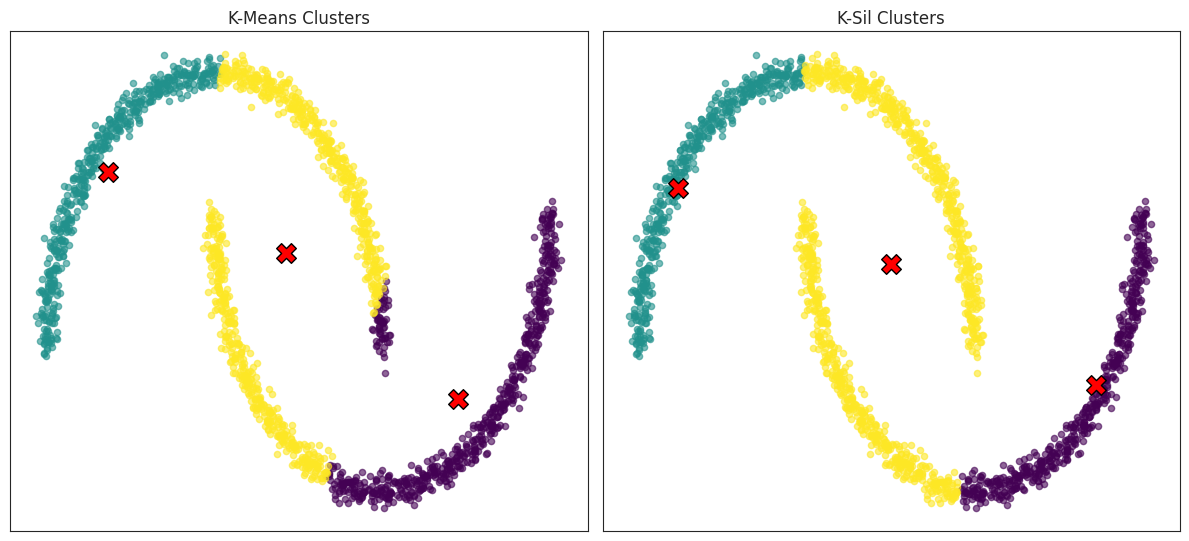

In [ ]:
X_moons, _ = make_moons(n_samples=2000, noise=0.029, random_state=42)
anim = run_ksil_demo(X_moons, dataset_name='Moons', k=3, init_method='random', sensitivity=5)

---

### Example 2.

<ipython-input-3-f77828a915fd>:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X2 = np.random.multivariate_normal(new_mean5, cov5, size=2000)


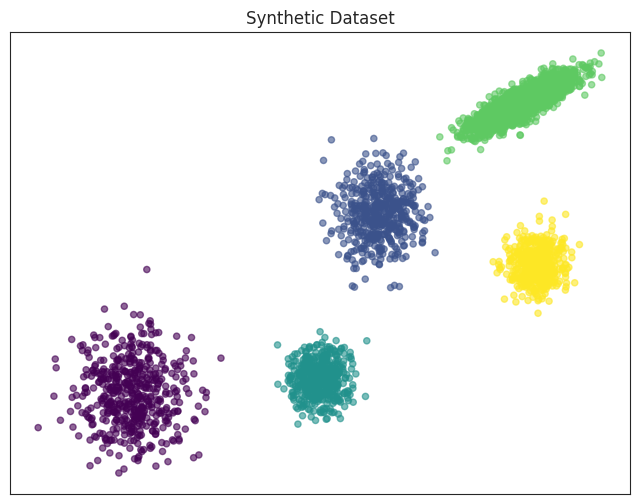

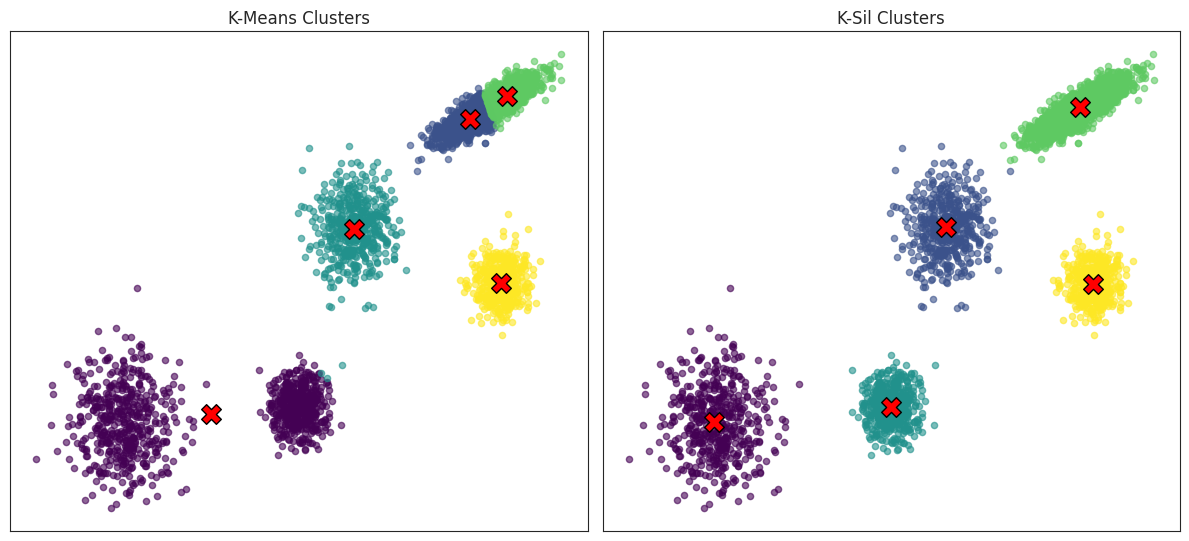

In [ ]:
centers = [
    (-8, -6),
    (9, 5),
    (20, 2),
    (5, -5),
    (10, 8)
]
cluster_std = [2, 1.5, 1, 1.0, 0]

X1, y1 = make_blobs(n_samples=2000, centers=centers[:4], cluster_std=cluster_std[:4], random_state=42)

new_mean5 = np.array((19, 12))
cov5 = np.array([[3, 1.5], [1.5, 0.5]])
X2 = np.random.multivariate_normal(new_mean5, cov5, size=2000)
y2 = np.full(2000, 4)

X = np.vstack([X1, X2])
y = np.concatenate([y1, y2])

label_map = {0: 0, 1: 1, 2: 4, 3: 2, 4: 3}
y = np.array([label_map[label] for label in y])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20, alpha=0.6)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Synthetic Dataset")
plt.show()

anim = run_ksil_demo(
    data=X,
    dataset_name="Synthetic Dataset",
    k=5,
    sensitivity=1,
    init_method='random',
    primary_measure='macro',
    sample_size=-1
)

---

### Example 3.

<ipython-input-4-503dfe3ebec6>:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X2 = np.random.multivariate_normal(mean5, cov5, size=2000)
/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


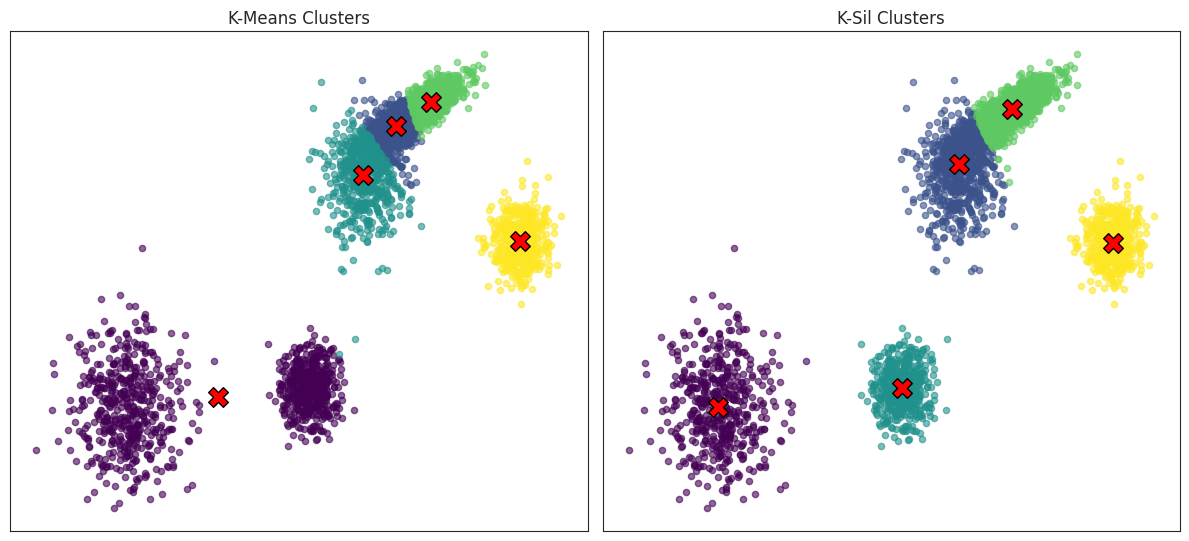

In [ ]:
centers = [
    (-8, -6),
    (9, 5),
    (20, 2),
    (5, -5),
    (12, 8)
]

cluster_std = [2, 1.5, 1, 1.0, 0]

X1, _ = make_blobs(n_samples=2000, centers=centers[:4], cluster_std=cluster_std[:4], random_state=42)

mean5 = np.array(centers[4])
cov5 = np.array([[3, 1.5], [1.5, 0.5]])

X2 = np.random.multivariate_normal(mean5, cov5, size=2000)

X = np.vstack([X1, X2])
X_coc = X

anim = run_ksil_demo(
    data=X,
    dataset_name="Synthetic Dataset",
    k=5,
    sensitivity=1,
    init_method='random',
    primary_measure='macro',
    sample_size=-1
)

---

### Example 4.

<ipython-input-5-273687bd3dde>:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X2 = np.random.multivariate_normal(mean_elliptical, cov_elliptical, size=2000)
/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


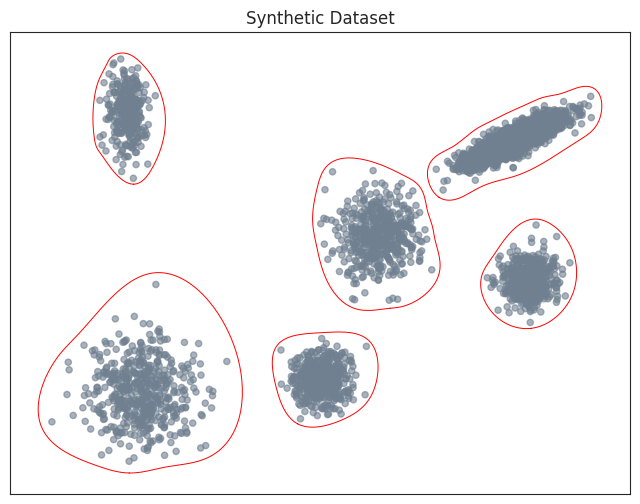

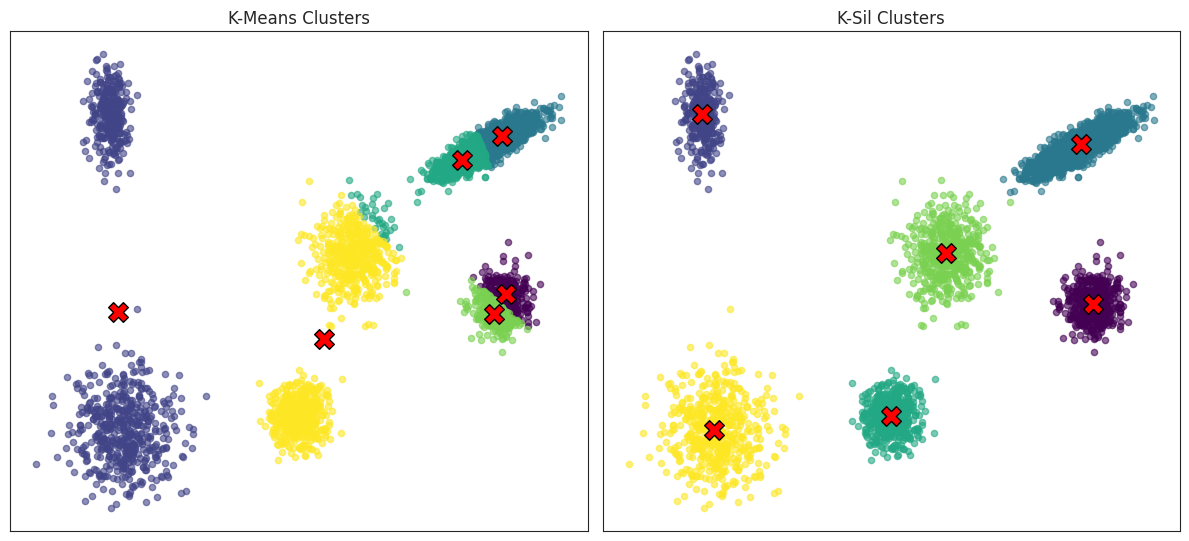

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
original_centers = [
    (-8, -6),
    (9, 5),
    (20, 2),
    (5, -5)
]
original_std = [2, 1.5, 1, 1.0]
X1, y1 = make_blobs(n_samples=2000, centers=original_centers,
                    cluster_std=original_std, random_state=42)

mean_elliptical = np.array([19, 12])
cov_elliptical = np.array([[3, 1.5], [1.5, 0.5]])
X2 = np.random.multivariate_normal(mean_elliptical, cov_elliptical, size=2000)
y2 = np.full(2000, 4)

mean_new = np.array([-9, 14])
cov_new = np.array([[0.5, 0], [0, 2.5]])
X_new = np.random.multivariate_normal(mean_new, cov_new, size=300)
y_new = np.full(300, 5)

X = np.vstack([X1, X2, X_new])
y = np.concatenate([y1, y2, y_new])

label_map = {0: 0, 1: 1, 2: 4, 3: 2, 4: 3, 5: 5}
y_mapped = np.array([label_map[label] for label in y])

teal_colors = ["slategrey","slategrey","slategrey","slategrey","slategrey","slategrey"]
custom_cmap = ListedColormap(teal_colors)


fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=y_mapped, cmap=custom_cmap, s=20, alpha=0.6)
ax.set_title("Synthetic Dataset")
ax.set_xticks([])
ax.set_yticks([])

unique_labels = np.unique(y_mapped)
for label in unique_labels:
    cluster_points = X[y_mapped == label]
    if len(cluster_points) < 3:
        continue

    hull = MultiPoint(cluster_points).convex_hull
    coords = np.array(hull.exterior.coords)
    if len(coords) < 3:
        continue

    try:
        tck, u = splprep([coords[:, 0], coords[:, 1]], s=0, per=True)
        u_fine = np.linspace(0, 1, 200)
        smooth_coords = np.array(splev(u_fine, tck)).T
    except Exception:
        smooth_coords = coords

    smooth_poly = Polygon(smooth_coords)
    avg_dim = np.mean([smooth_poly.bounds[2] - smooth_poly.bounds[0],
                       smooth_poly.bounds[3] - smooth_poly.bounds[1]])
    buffer_dist = 0.065 * avg_dim
    smooth_poly = smooth_poly.buffer(buffer_dist)

    x_poly, y_poly = smooth_poly.exterior.xy
    ax.plot(x_poly, y_poly, color="red", lw=0.7)

plt.show()

anim = run_ksil_demo(
    data=X,
    dataset_name="Synthetic Data",
    k=6,
    sensitivity=1,
    init_method='random',
    primary_measure='macro',
    sample_size=-1
)

---

### Example 5.

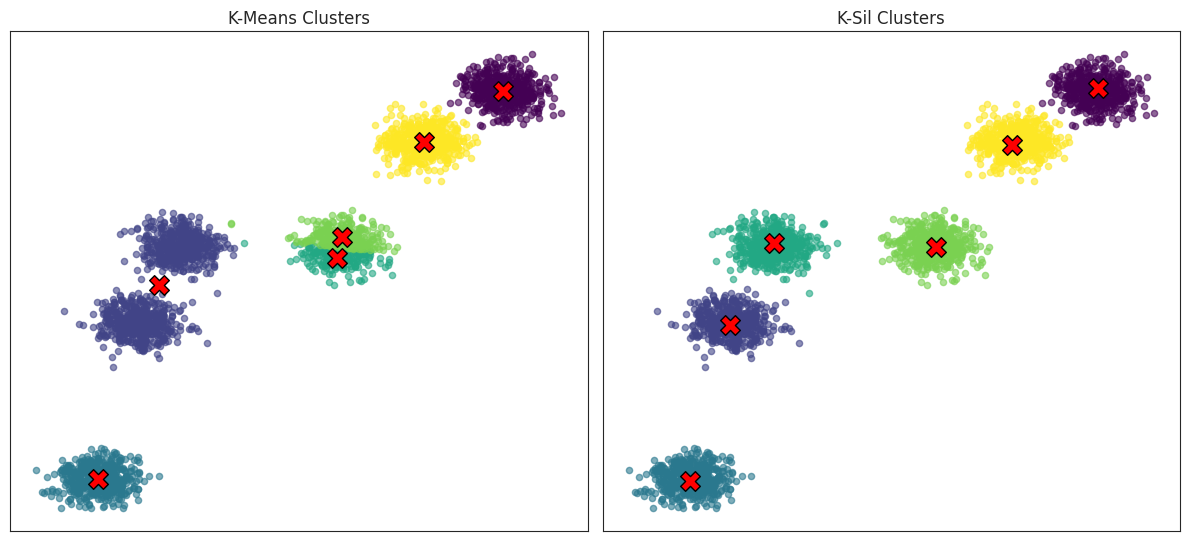

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
centers = [(5, 3), (1, 3), (-1, -6), (0,0), (7,7), (9,9)]
X, y = make_blobs(n_samples=3000, centers=centers, cluster_std=0.5, random_state=0)
X = np.array(X)

anim=run_ksil_demo(
    data=X,
    dataset_name="Synthetic Dataset",
    k=6,
    sensitivity=5,
    init_method='random',
    primary_measure='macro',
    sample_size=-1
)

---

## Weight Sensitivity & Silhouette

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from sklearn.datasets import make_blobs, load_iris, load_wine, load_digits, fetch_openml, fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

X_1, y_1 = make_blobs(n_samples=500, centers=5,
                      cluster_std=[1.0, 2.5, 0.5, 1.5, 3.0],
                      random_state=42)
k_1 = len(np.unique(y_1))


X_2, y_2 = make_blobs(n_samples=500, centers=5, n_features=12,
                      cluster_std=1.0, random_state=42)
k_2 = len(np.unique(y_2))


X_3, y_3 = make_blobs(n_samples=500, centers=5, n_features=12,
                      cluster_std=2.5, random_state=42)
k_3 = len(np.unique(y_3))

def generate_ring_and_line_with_noise(n_points=1000, noise_ratio=0.5, ring_radius=5, ring_thickness=0.5, line_length=10):
    np.random.seed(42)
    n_noise = int(n_points * noise_ratio)
    n_cluster = n_points - n_noise
    n_per_cluster = n_cluster // 2

    angles = np.random.uniform(0, 2*np.pi, n_per_cluster)
    radii = np.random.normal(ring_radius, ring_thickness, n_per_cluster)
    x_ring = radii * np.cos(angles)
    y_ring = radii * np.sin(angles)

    x_line = np.random.normal(0, 0.3, n_per_cluster)
    y_line = np.random.uniform(-line_length/2, line_length/2, n_per_cluster)

    box_size = ring_radius * 3
    noise_x = np.random.uniform(-box_size, box_size, n_noise)
    noise_y = np.random.uniform(-box_size, box_size, n_noise)

    X = np.vstack([
        np.column_stack([x_ring, y_ring]),
        np.column_stack([x_line, y_line]),
        np.column_stack([noise_x, noise_y])
    ])

    y_ring = np.zeros(n_per_cluster, dtype=int)
    y_line = np.ones(n_per_cluster, dtype=int)
    y_noise = np.full(n_noise, 2, dtype=int)
    y_true = np.concatenate([y_ring, y_line, y_noise])
    return X, y_true

X_4, y_4 = generate_ring_and_line_with_noise(n_points=1500,
                                             noise_ratio=0.5,
                                             ring_radius=5,
                                             ring_thickness=0.5,
                                             line_length=10)
k_4 = len(np.unique(y_4))

iris = load_iris()
X_iris = iris.data
y_iris = iris.target
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)
k_iris = len(np.unique(y_iris))

data_mice = fetch_openml(name='MiceProtein', version=4, as_frame=False)
X_mice = data_mice.data
y_mice = data_mice.target
imputer = SimpleImputer(strategy='mean')
X_mice = imputer.fit_transform(X_mice)
scaler = StandardScaler()
X_mice = scaler.fit_transform(X_mice)
k_mice = len(np.unique(y_mice))


data_glass = fetch_openml(name='glass', version=1, as_frame=False)
X_glass = data_glass.data
y_glass = data_glass.target
scaler = StandardScaler()
X_glass = scaler.fit_transform(X_glass)
k_glass = len(np.unique(y_glass))

wine = load_wine()
X_wine = wine.data
y_wine = wine.target
pca = PCA(n_components=0.95)
X_wine = pca.fit_transform(X_wine)
k_wine = len(np.unique(y_wine))

digits = load_digits()
X_digits = digits.data
y_digits = digits.target
pca = PCA(n_components=0.95)
X_digits = pca.fit_transform(X_digits)
k_digits = len(np.unique(y_digits))

categories_o = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.autos', 'rec.motorcycles']
newsgroups_o = fetch_20newsgroups(categories=categories_o, remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_tfidf = vectorizer.fit_transform(newsgroups_o.data)
X_tfidf = X_tfidf.toarray()
X_tfidf = PCA(0.90).fit_transform(X_tfidf)
X_newsgroups = X_tfidf
y_newsgroups = newsgroups_o.target
k_newsgroups = len(np.unique(y_newsgroups))

datasets = {
    "S1": (X_1, k_1),
    "S2": (X_2, k_2),
    "S3": (X_3, k_3),
    "S4": (X_4, k_4),
    "Iris": (X_iris, k_iris),
    "Mice Protein": (X_mice, k_mice),
    "Glass": (X_glass, k_glass),
    "Wine": (X_wine, k_wine),
    "Digits": (X_digits, k_digits),
    "20 Newsgroups Subset": (X_newsgroups, k_newsgroups)
}


def run_ksil_experiment(X, k, sensitivity, weighting, obj):
    ksil = KSilDemo(n_clusters=k, weighting=weighting, sensitivity=sensitivity,
                    max_iter=50, random_state=42, silhouette_objective=obj, sample_size=-1)
    ksil.fit(X)
    if obj=='macro':
        score = Silhouette.Macro(X, ksil.labels_)
    else:
        score = Silhouette.Micro(X, ksil.labels_)
    return score

sensitivity_values = np.arange(0, 21)

results = {}

for name, (X, k) in datasets.items():
    #print(f"Processing dataset: {name}")
    power_scores = []
    exponential_scores = []
    for s in sensitivity_values:
        # Run experiments for both weighting schemes
        score_power = run_ksil_experiment(X, k, s, weighting='power', obj='macro')
        score_expo = run_ksil_experiment(X, k, s, weighting='exponential', obj='macro')
        power_scores.append(score_power)
        exponential_scores.append(score_expo)
        #print(f"  Sensitivity={s:>2}: Power={score_power:.4f}, Exponential={score_expo:.4f}")
    results[name] = {"power": power_scores, "exponential": exponential_scores}

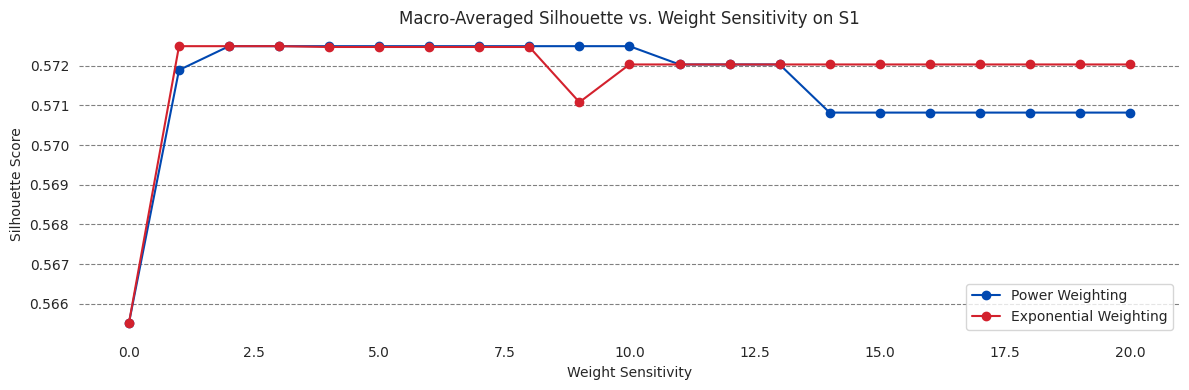

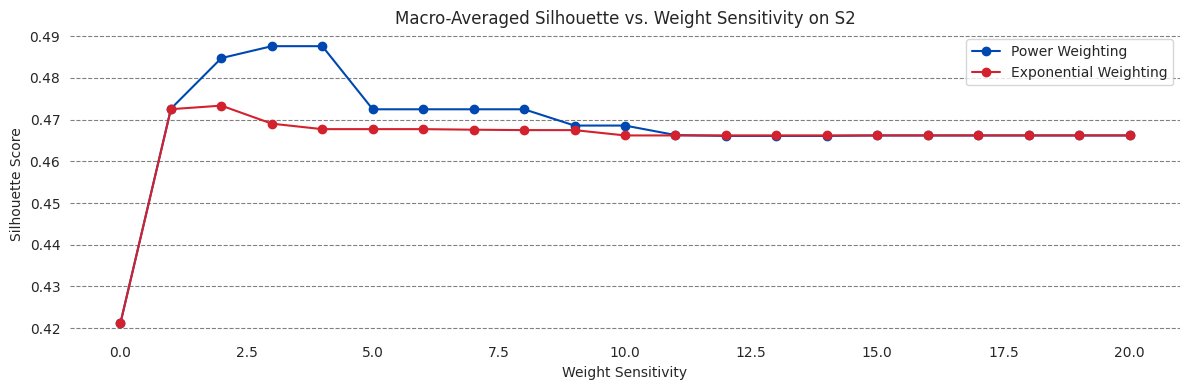

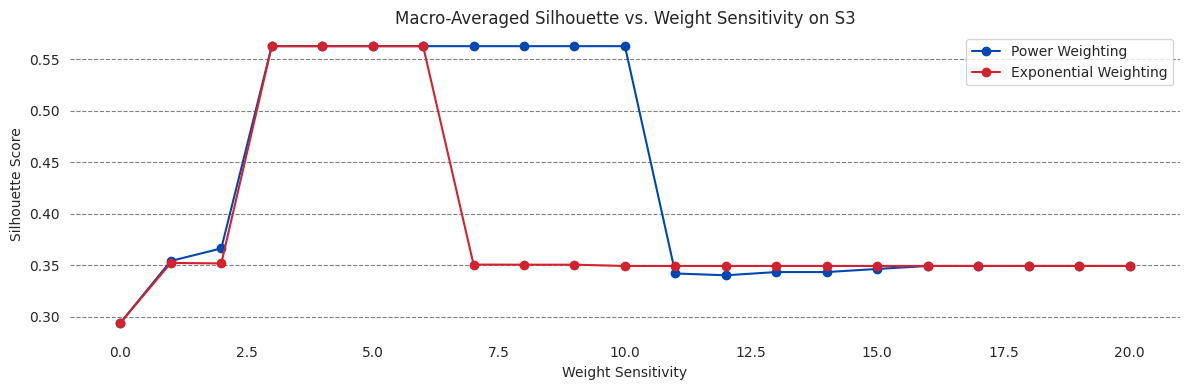

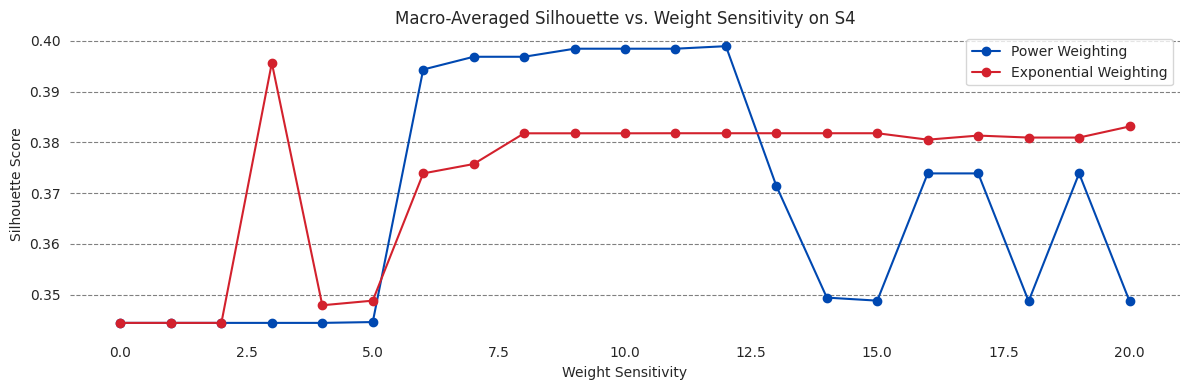

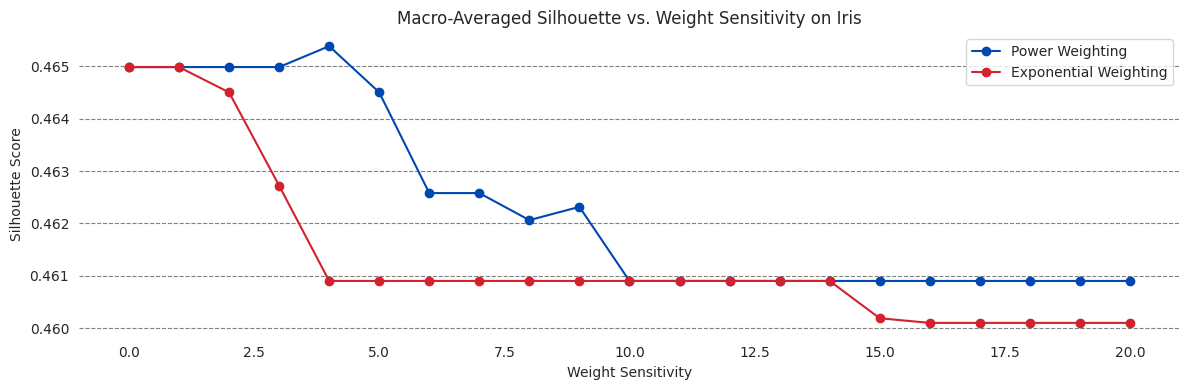

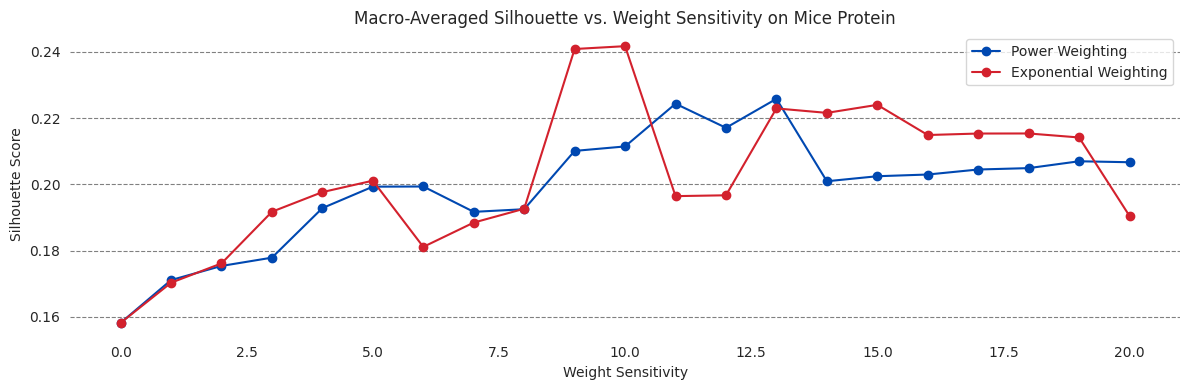

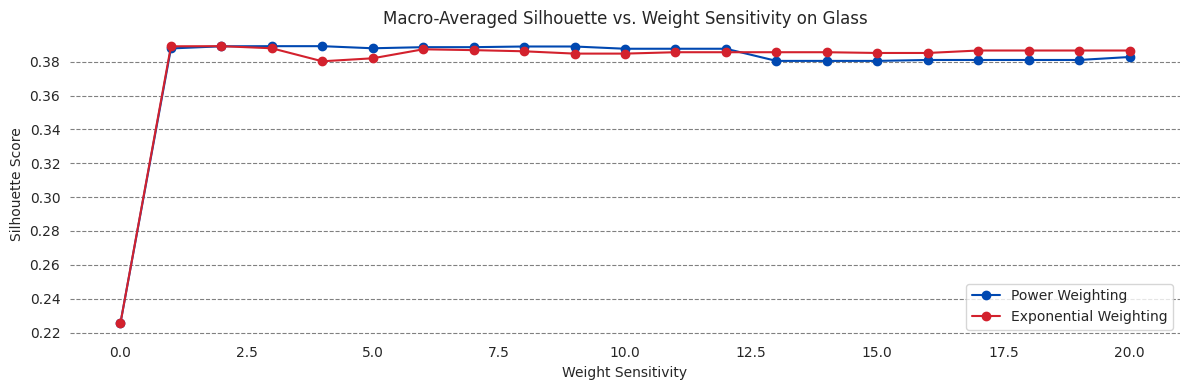

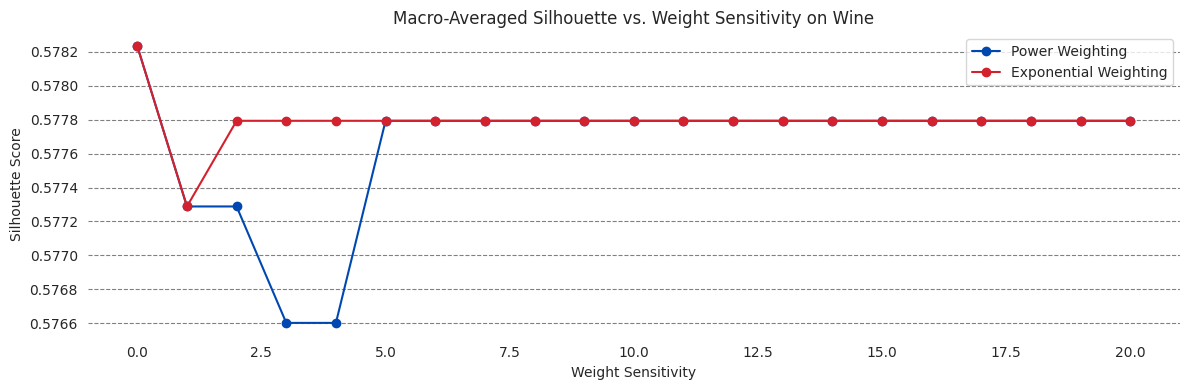

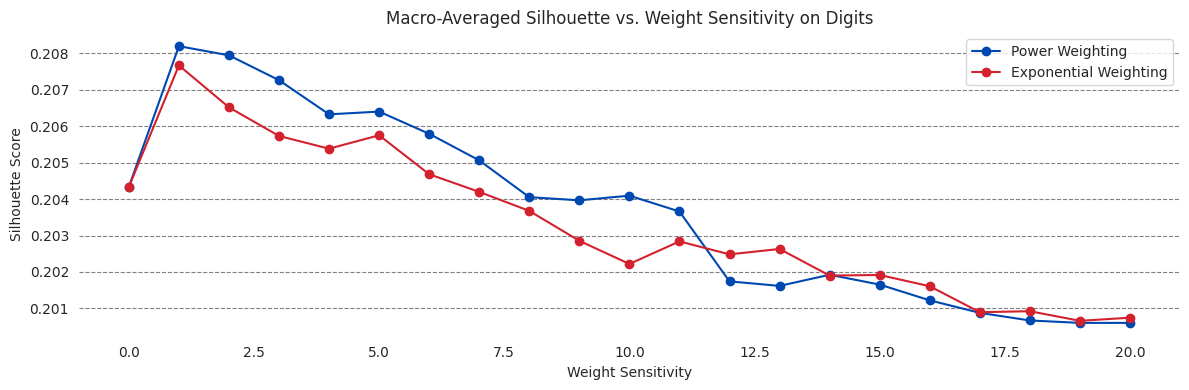

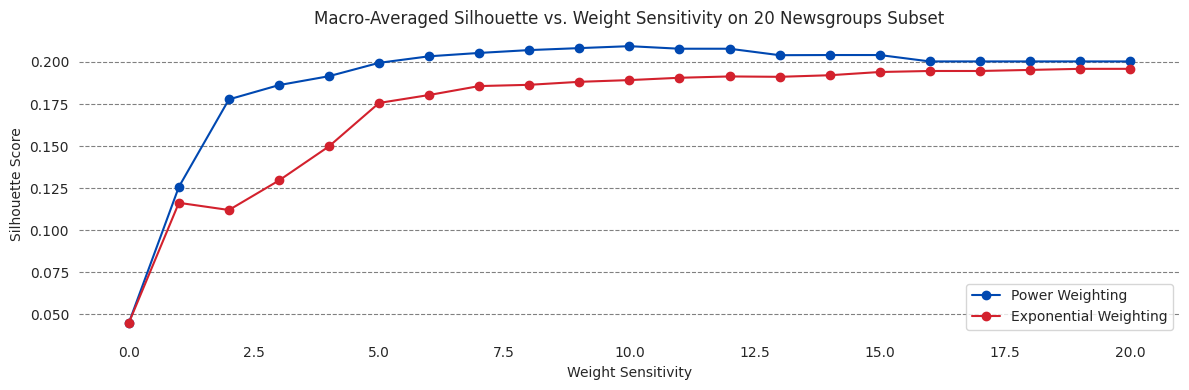

In [ ]:
for name, scores in results.items():
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(sensitivity_values, scores["power"], '-o', color='#0048B1', label='Power Weighting')
    ax.plot(sensitivity_values, scores["exponential"], '-o', color='#D3212D', label='Exponential Weighting')
    ax.set_xlabel("Weight Sensitivity")
    ax.set_ylabel("Silhouette Score")
    ax.set_title(f"Macro-Averaged Silhouette vs. Weight Sensitivity on {name}")
    ax.legend()
    ax.grid(color='gray', linestyle='--', axis='y', linewidth=0.8)

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()
